In [1]:
import os

os.environ["LD_LIBRARY_PATH"] = "/usr/lib/x86_64-linux-gnu"
os.environ["HF_TOKEN"] = "***"
os.environ["HF_HOME"] = "/media/petter/Data/HF"

import torch
from transformers import AutoModel, AutoConfig
from peft import LoraConfig, get_peft_model

model_id = "facebook/dinov3-vit7b16-pretrain-lvd1689m"
config = AutoConfig.from_pretrained(model_id)

from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float32 
)

backbone = AutoModel.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    output_hidden_states=True
)

peft_config = LoraConfig(
    r=16, 
    lora_alpha=32, 
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1, 
    bias="none"
)
backbone = get_peft_model(backbone, peft_config)

/home/petter/.pyenv/versions/3.13.2/envs/ia-project/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.59s/it]


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoConfig

class ReassembleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, patch_size=14, scale_factor=1.0):
        super().__init__()
        self.patch_size = patch_size
        self.scale_factor = scale_factor

        self.ln = nn.LayerNorm(in_channels)
        
        self.projection = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.resize_conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        B, N, C = x.shape
        
        # The number of patches must be a perfect square (e.g., 32*32=1024).
        # W_feat = floor(sqrt(N))
        W_feat = int((N)**0.5) 
        H_feat = W_feat
        
        num_patches = W_feat * H_feat
        
        num_extra_tokens = N - num_patches
        
        # Discard the extra tokens from the beginning of the sequence
        if num_extra_tokens > 0:
            x = x[:, num_extra_tokens:, :]

        x = self.ln(x)
        
        x = x.permute(0, 2, 1).reshape(B, C, H_feat, W_feat)
        
        x = self.projection(x)
        
        if self.scale_factor != 1.0:
            x = F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')

        x = self.resize_conv(x)

        return x

class DepthAnythingDINOv3(nn.Module):
    def __init__(self, backbone_model_id, feature_layer_indices, decoder_channels=256):
        super().__init__()
        
        self.backbone_config = AutoConfig.from_pretrained(backbone_model_id)
        self.backbone_config.output_hidden_states = True
        
        self.backbone = AutoModel.from_pretrained(backbone_model_id, config=self.backbone_config)
        
        self.indices = feature_layer_indices
        embed_dim = self.backbone_config.hidden_size
        patch_size = getattr(self.backbone_config, "patch_size", 14)

        self.reassemble_blocks = nn.ModuleList([
            ReassembleBlock(embed_dim, decoder_channels, patch_size, scale_factor=4.0),
            ReassembleBlock(embed_dim, decoder_channels, patch_size, scale_factor=2.0),
            ReassembleBlock(embed_dim, decoder_channels, patch_size, scale_factor=1.0),
            ReassembleBlock(embed_dim, decoder_channels, patch_size, scale_factor=0.5), 
        ])
        
        self.fusion_blocks = nn.ModuleList([
            nn.Conv2d(decoder_channels, decoder_channels, 3, padding=1) 
            for _ in range(len(feature_layer_indices))
        ])

        self.head = nn.Sequential(
            nn.Conv2d(decoder_channels, decoder_channels // 2, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(decoder_channels // 2, 1, 1),
            nn.ReLU()
        )
    def forward(self, x):
        outputs = self.backbone(x)
        hidden_states = outputs.hidden_states 
        
        selected_features = [hidden_states[i].float() for i in self.indices]

        processed_features = []
        for feat, reassemble in zip(selected_features, self.reassemble_blocks):
            processed_features.append(reassemble(feat))
            
        out = processed_features[-1]
        for i in range(len(processed_features) - 2, -1, -1):
            target_shape = processed_features[i].shape[-2:]
            out = F.interpolate(out, size=target_shape, mode="bilinear", align_corners=False)
            out = out + self.fusion_blocks[i](processed_features[i])
            
        depth = self.head(out)
        
        return depth

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

indices = [9, 19, 29, 39] 

In [3]:
model = DepthAnythingDINOv3("facebook/dinov3-vit7b16-pretrain-lvd1689m", indices)
model.backbone = backbone

model.reassemble_blocks.float()
model.fusion_blocks.float()
model.head.float()


model.to(device)

Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 69.38it/s]


DepthAnythingDINOv3(
  (backbone): PeftModel(
    (base_model): LoraModel(
      (model): DINOv3ViTModel(
        (embeddings): DINOv3ViTEmbeddings(
          (patch_embeddings): Conv2d(3, 4096, kernel_size=(16, 16), stride=(16, 16))
        )
        (rope_embeddings): DINOv3ViTRopePositionEmbedding()
        (layer): ModuleList(
          (0-39): 40 x DINOv3ViTLayer(
            (norm1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
            (attention): DINOv3ViTAttention(
              (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
              (v_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): Module

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from datasets import load_dataset


CONFIG = {
    "model_id": "facebook/dinov3-vit7b16-pretrain-lvd1689m", 
    "hf_dataset": "sayakpaul/nyu_depth_v2", # The HF dataset ID
    "batch_size": 1,          
    "grad_accum_steps": 4,    
    "lr": 5e-6,               
    "epochs": 10,
    "image_size": 518,        
    "max_depth": 10.0,        
}

class HFDepthDataset(Dataset):
    def __init__(self, hf_split, image_size=518):
        """
        Args:
            hf_split: The specific split object from load_dataset (e.g., dataset['train'])
            image_size (int): Target size for resizing
        """
        self.data = hf_split
        self.image_size = image_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        img = sample['image']
        depth = sample['depth_map']

        img = img.resize((self.image_size, self.image_size), resample=2)
        depth = depth.resize((self.image_size, self.image_size), resample=0)

        img_np = np.array(img) / 255.0
        
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = (img_np - mean) / std
        
        img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).float()

        depth_np = np.array(depth).astype(np.float32)

        # 'sayakpaul/nyu_depth_v2' typically provides 8-bit depth (0-255).
        # We need to scale this back to real-world meters (0-10m).
        if depth_np.max() > 10.0:
            depth_np = depth_np / 255.0 * CONFIG["max_depth"]
            
        depth_tensor = torch.from_numpy(depth_np).unsqueeze(0).float()

        return img_tensor, depth_tensor

class SiLogLoss(torch.nn.Module):
    def __init__(self, lambd=0.5, log_scale=True):
        super().__init__()
        self.lambd = lambd
        self.log_scale = log_scale

    def forward(self, pred, target):
        pred = pred.float()
        target = target.float()

        pred = pred.view(pred.shape[0], -1)
        target = target.view(target.shape[0], -1)

        valid_mask = (target > 0.001) & (target <= CONFIG["max_depth"])

        if valid_mask.sum() == 0:
            return torch.tensor(0.0, device=pred.device, requires_grad=True)

        # We clamp predictions to avoid log(0)
        if self.log_scale:
            pred_safe = torch.clamp(pred[valid_mask], min=0.001)
            target_safe = target[valid_mask]

            log_diff = torch.log(pred_safe) - torch.log(target_safe)
        else:
            log_diff = pred[valid_mask] - target[valid_mask]

        diff_sq = torch.mean(log_diff ** 2)
        diff_mean = torch.mean(log_diff) ** 2

        variance_term = torch.clamp(diff_sq - self.lambd * diff_mean, min=1e-8)

        return torch.sqrt(variance_term)

def compute_metrics(pred, target):
    """
    Computes standard depth metrics: AbsRel and Delta Accuracy.
    """
    valid_mask = (target > 0.001) & (target <= CONFIG["max_depth"])
    
    if valid_mask.sum() == 0:
        return None

    p = pred[valid_mask]
    t = target[valid_mask]

    abs_rel = torch.mean(torch.abs(p - t) / t)

    thresh = torch.max((t / p), (p / t))
    a1 = (thresh < 1.25).float().mean()

    return abs_rel.item(), a1.item()

def validate(model, dataloader, criterion, device):
    model.eval()
    
    total_loss = 0.0
    total_abs_rel = 0.0
    total_a1 = 0.0
    num_batches = 0
    
    print("Running Validation...")
    
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Val"):
            images, targets = images.to(device), targets.to(device)
            
            preds = model(images)
            
            if preds.shape[-2:] != targets.shape[-2:]:
                preds = F.interpolate(preds, size=targets.shape[-2:], mode='bilinear', align_corners=False)
            
            loss = criterion(preds, targets)
            
            metrics = compute_metrics(preds.float(), targets.float())
            
            if metrics is not None:
                abs_rel, a1 = metrics
                total_abs_rel += abs_rel
                total_a1 += a1
                total_loss += loss.item()
                num_batches += 1

    if num_batches > 0:
        avg_loss = total_loss / num_batches
        avg_abs_rel = total_abs_rel / num_batches
        avg_a1 = total_a1 / num_batches
    else:
        avg_loss, avg_abs_rel, avg_a1 = 0.0, 0.0, 0.0

    print(f"Validation Results -> Loss: {avg_loss:.4f} | AbsRel: {avg_abs_rel:.3f} | Acc(a1): {avg_a1:.3f}")
    
    model.train()
    return avg_loss, avg_abs_rel, avg_a1 


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")

print(f"Loading dataset: {CONFIG['hf_dataset']}...")
full_dataset = load_dataset(CONFIG['hf_dataset'])

train_dataset = HFDepthDataset(full_dataset['train'], image_size=CONFIG['image_size'])
val_dataset = HFDepthDataset(full_dataset['validation'], image_size=CONFIG['image_size'])

train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG["batch_size"], 
    shuffle=True, 
    num_workers=4,
    pin_memory=True
)

print(f"Training samples: {len(train_dataset)}")

optimizer = AdamW(model.parameters(), lr=CONFIG["lr"], weight_decay=0.01)
criterion = SiLogLoss()

train_losses = []
train_abs_rels = []
train_a1s = []

val_losses = []
val_abs_rels = []
val_a1s = []

model.train()

for epoch in range(CONFIG["epochs"]):
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']}")

    epoch_abs_rel = 0.0
    epoch_a1 = 0.0
    num_batches = 0
    
    for batch_idx, (images, targets) in enumerate(pbar):
        images, targets = images.to(device), targets.to(device)

        if images.dtype != torch.float32:
            images = images.float()
        
        preds = model(images)

        if preds.shape[-2:] != targets.shape[-2:]:
            preds = F.interpolate(preds, size=targets.shape[-2:], mode='bilinear', align_corners=False)
        
        loss = criterion(preds, targets)
        loss = loss / CONFIG["grad_accum_steps"]

        loss.backward()

        if (batch_idx + 1) % CONFIG["grad_accum_steps"] == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        metrics = compute_metrics(preds.float(), targets.float())

        if metrics is not None:
            abs_rel, a1 = metrics
            epoch_abs_rel += abs_rel
            epoch_a1 += a1
            num_batches += 1
        
        current_loss = loss.item() * CONFIG["grad_accum_steps"]
        epoch_loss += current_loss
        pbar.set_postfix({"loss": f"{current_loss:.4f}"})

    if num_batches > 0:
        avg_loss = epoch_loss / num_batches
        avg_abs_rel = epoch_abs_rel / num_batches
        avg_a1 = epoch_a1 / num_batches
    else:
        avg_loss, avg_abs_rel, avg_a1 = 0.0, 0.0, 0.0
    train_losses.append(avg_loss)
    train_abs_rels.append(avg_abs_rel)
    train_a1s.append(avg_a1)
        
    print(f"Epoch {epoch+1} Train Loss: {epoch_loss / len(train_loader):.4f}")
    
    if val_loader is not None:
        val_loss, val_abs_rel, val_a1 = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_abs_rels.append(val_abs_rel)
        val_a1s.append(val_a1)
    
    # Save Checkpoint
    torch.save(model.state_dict(), f"dinov3_depth_epoch_{epoch+1}.pth")

In [ ]:
print("Train losses:", train_losses)
print("Train abs rels:", train_abs_rels)
print("Train a1s:", train_a1s)
print("Val losses:", val_losses)
print("Val abs rels:", val_abs_rels)
print("Val a1s:", val_a1s)

In [ ]:
def training_curve_plot(title, x, train_costs, test_costs, train_accuracy, test_accuracy, batch_size, learning_rate):
    """Plotting function copied from assignment instructions"""
    lg=18
    md=13
    sm=9
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=1.15, fontsize=lg)
    sub = f'| Batch size:{batch_size} | Learning rate:{learning_rate} |'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
    axs[0].plot(x, train_costs, label=f'Final train cost: {train_costs[-1]:.4f}')
    axs[0].plot(x, test_costs, label=f'Final test cost: {test_costs[-1]:.4f}')
    axs[0].set_title('Costs', fontsize=md)
    axs[0].set_xlabel('Iteration', fontsize=md)
    axs[0].set_ylabel('Cost', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    axs[1].plot(x, train_accuracy, label=f'Final train accuracy: {100*train_accuracy[-1]:.2f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test accuracy: {100*test_accuracy[-1]:.2f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Iterations', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)
    plt.show()

In [ ]:
training_curve_plot("Depth Anything (DINOv3)", [x for x in range(20)], train_losses, val_losses, train_a1s, val_a1s, 8, 5e-6)

In [4]:
def load_checkpoint(model, path):
    checkpoint = torch.load(path, map_location='cpu', weights_only=True)

    clean_state_dict = {}

    for key, value in checkpoint.items():
        if any(part in key for part in ["reassemble_blocks", "fusion_blocks", "head"]):
            clean_state_dict[key] = value

        elif "lora_" in key:
            clean_state_dict[key] = value

    model.load_state_dict(clean_state_dict, strict=False)

In [12]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def infer_and_plot(model, image_path, device="cuda"):
    model.eval()
    model.to(device)
    
    try:
        raw_image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    orig_w, orig_h = raw_image.size
    min_dim = min(orig_w, orig_h)
    
    left = (orig_w - min_dim) // 2
    top = (orig_h - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim
    
    cropped_image = raw_image.crop((left, top, right, bottom))
    
    input_size = 518
    input_pil = cropped_image.resize((input_size, input_size), Image.BILINEAR)
    
    img_np = np.array(input_pil) / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = (img_np - mean) / std
    
    img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).float().to(device)

    with torch.no_grad():
        pred_depth = model(img_tensor)

        pred_depth = F.interpolate(
            pred_depth, 
            size=(min_dim, min_dim), 
            mode='bilinear', 
            align_corners=False
        )

    depth_map = pred_depth.squeeze().cpu().numpy()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(cropped_image)
    axes[0].set_title("Input (Center Crop)")
    axes[0].axis("off")

    depth_plot = axes[1].imshow(depth_map, cmap="magma_r") 
    axes[1].set_title("Predicted Depth Map")
    axes[1].axis("off")
    
    cbar = fig.colorbar(depth_plot, ax=axes[1], fraction=0.046, pad=0.04)
    cbar.set_label('Depth (meters)')
    
    plt.tight_layout()
    plt.show()

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 147.65it/s]


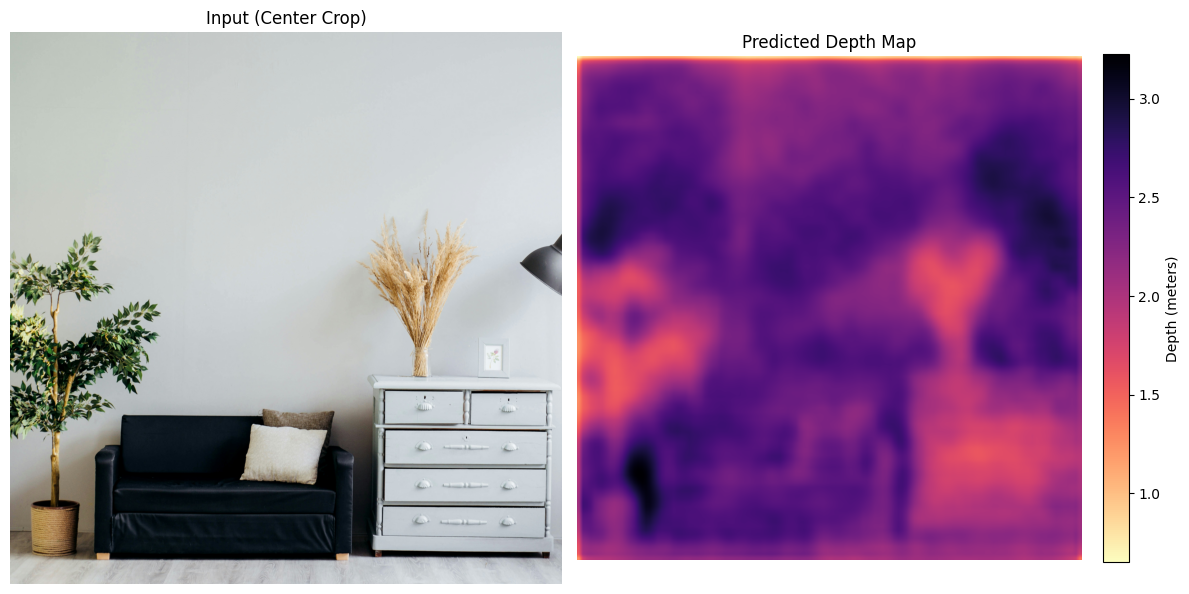

In [11]:
indices = [9, 19, 29, 39] 
best_model = DepthAnythingDINOv3(model_id, indices)
best_model.backbone = backbone

best_model.reassemble_blocks.float()
best_model.fusion_blocks.float()
best_model.head.float()

load_checkpoint(best_model, 'dinov3_depth_epoch_19.pth')
best_model.to(device)
infer_and_plot(best_model, "test_room.jpg")